In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib import rcParams

import sys
import os
import glob2
from tqdm import tqdm

import ast
import pandas as pd

from chatty_boi import *

In [3]:
with open("./prompt_lib_swr/base_prompt_swr.txt", "r") as f:
    prompt = f.read()

with open("./prompt_lib_swr/constraint_prompt_swr.txt", "r") as f:
    constraints_prompt = f.read()

with open("./prompt_lib_swr/optimize_prompt_swr.txt", "r") as f:
    optimize_prompt = f.read()

input_data = {}
with open("./prompt_lib_swr/base_inputs_swr.txt", "r") as f:
    exec(f.read(),{}, input_data)


base_prompt = prompt
constraints_prompt = constraints_prompt
optimize_prompt = optimize_prompt

node_dict_input = input_data["node_dict_input"]
example_members_input = input_data["example_members_input"]
area_id = input_data["area_id"]
load = input_data["load"]
supports = input_data["supports"]


In [4]:
# Find all files matching the pattern in subfolders run_{j} and inside runs folder _step_{iteration}_{attempt}
import re

base_dir = './results_final_runs/responses_q2/'
pattern = os.path.join(base_dir, '*', 'run_*', '_step_*_*')
all_files = glob2.glob(pattern)

# Organize files by their parent directories (the folder inside ./responses)
file_dict = {}
for f in all_files:
    parts = f.split(os.sep)
    if len(parts) < 4:
        continue
    parent = parts[3]  # e.g., q1p1_s15W30_nano_t1
    # print(parent)
    run_folder = parts[4]  # e.g., run_1
    if parent not in file_dict:
        file_dict[parent] = {}
    if run_folder not in file_dict[parent]:
        file_dict[parent][run_folder] = []
    file_dict[parent][run_folder].append(f)

# Optionally, sort the files within each run folder
for parent in file_dict:
    for run_folder in file_dict[parent]:
        file_dict[parent][run_folder].sort()

# Convert to DataFrame for display
rows = []
for parent, runs in file_dict.items():
    for run, files in runs.items():
        for file in files:
            rows.append({'parent': parent, 'run': run, 'file': file})
df_files = pd.DataFrame(rows)


In [5]:
p= 'q2p1_s05W30_gpt_t1'
r = "run_1"

files = list(df_files[(df_files["parent"] == p) & (df_files["run"] == r)]["file"])

num_failed = 0
for i in files:
    attempsts = i.split("_")[-1]
    print(attempsts, i)

0.txt ./results_final_runs/responses_q2/q2p1_s05W30_gpt_t1/run_1/_step_0_0.txt
1.txt ./results_final_runs/responses_q2/q2p1_s05W30_gpt_t1/run_1/_step_1_1.txt
0.txt ./results_final_runs/responses_q2/q2p1_s05W30_gpt_t1/run_1/_step_2_0.txt


In [6]:
# Get all files for a given parent and run, sorted by step number
import re

def extract_step_number(filename):
    # Matches _step_{step}_{attempt} (step can be multiple digits)
    m = re.search(r'_step_(\d+)_', os.path.basename(filename))
    return int(m.group(1)) if m else -1

def get_files_for_parent_run(parent, run):
    files = file_dict.get(parent, {}).get(run, [])
    return sorted(files, key=extract_step_number)
def get_sorted_runs_for_parent(parent):
    runs = file_dict.get(parent, {}).keys()
    return sorted(runs, key=lambda x: int(x.split("_")[1]))


In [19]:
# Example usage:
parent = 'q2p3_s1W30_gpt_t05'  # replace with desired parent
run = 'run_1'                   # replace with desired run
files = get_files_for_parent_run(parent, run)

sorted_runs = get_sorted_runs_for_parent(parent)
print(sorted_runs)

sorted_runs= ["run_1", "run_4", "run_8"]

['run_0', 'run_1', 'run_2', 'run_3', 'run_4', 'run_5', 'run_6', 'run_7', 'run_8', 'run_9']


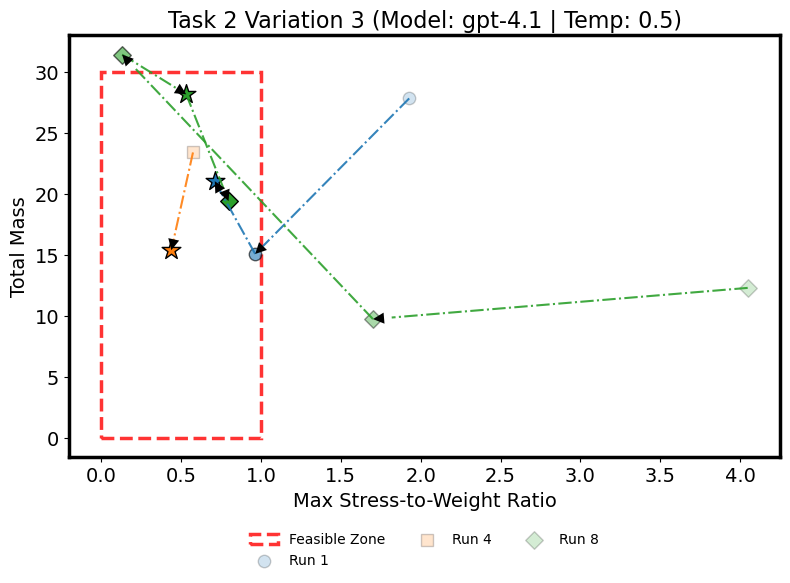

In [22]:
import ast
import numpy as np
import matplotlib.pyplot as plt

# ---- CONSTRAINTS ----
max_swr_allow     = 1.0   # maximum allowable stress-to-weight ratio
total_mass_allow  = 30    # maximum allowable total mass

fig, ax = plt.subplots(figsize=(8, 6))
n_runs = len(sorted_runs)

# ---- CUSTOM COLORS & MARKERS ----
custom_colors  = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red',
                  'tab:purple', 'tab:brown',  'tab:pink',  'tab:gray',
                  'tab:olive', 'tab:cyan']
marker_styles  = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']

# ---- DRAW CONSTRAINT ZONE ON SWR vs MASS ----
rect = plt.Rectangle(
    (0, 0),
    max_swr_allow, total_mass_allow,
    linewidth=2.5, edgecolor='red', facecolor='none',
    linestyle='--', alpha=0.8,
    label='Feasible Zone'
)
ax.add_patch(rect)

for idx, run in enumerate(sorted_runs):
    files       = get_files_for_parent_run(parent, run)
    swr_vals    = []
    mass_vals   = []
    for fn in files:
        with open(fn, 'r') as f:
            gen    = ast.literal_eval(f.read())
        parsed      = TrussOutput.model_validate(gen)
        t           = make_truss(parsed.node_dict, parsed.member_dict, load, supports)
        _, res      = make_result_dict(t.member_stress(), t.structure_mass(), print_=False)
        swr_vals.append(res['max_stress_to_weight_ratio'])
        mass_vals.append(res['total_mass'])

    steps = np.arange(len(files))
    base_color = custom_colors[idx % len(custom_colors)]
    marker     = marker_styles[idx % len(marker_styles)]
    alphas     = np.linspace(0.2, 1.0, len(steps))

    # find the "best" step: first inside, otherwise closest to zone
    inside = [i for i in steps if (swr_vals[i] <= max_swr_allow) and (mass_vals[i] <= total_mass_allow)]
    if inside:
        best_idx = inside[np.argmin([swr_vals[i] for i in inside])]
    else:
        def dist(i):
            swr_over  = max(0, swr_vals[i] - max_swr_allow)
            mass_over = max(0, mass_vals[i] - total_mass_allow)
            return np.hypot(swr_over, mass_over)
        best_idx = np.argmin([dist(i) for i in steps])

    # plot each step
    for i in steps:
        label = f'Run {run.split("_")[1]}' if i == 0 else None
        if i == best_idx:
            ax.scatter(
                swr_vals[i], mass_vals[i],
                color=base_color, edgecolor='k', s=200,
                marker='*', label=None
            )
        else:
            ax.scatter(
                swr_vals[i], mass_vals[i],
                color=base_color, alpha=alphas[i],
                edgecolor='k', s=80,
                marker=marker,
                label=label
            )

    # connect points with dashed lines + arrowheads
    for i in range(len(steps) - 1):
        x0, y0 = swr_vals[i],     mass_vals[i]
        x1, y1 = swr_vals[i + 1], mass_vals[i + 1]
        dx, dy = x1 - x0, y1 - y0
        end_fraction = 0.95
        xe = x0 + end_fraction * dx
        ye = y0 + end_fraction * dy

        ax.plot([x0, xe], [y0, ye],
                linestyle='-.', color=base_color, lw=1.5, alpha=0.9)
        ax.annotate('', xy=(x1, y1), xytext=(xe, ye),
                    arrowprops=dict(
                        arrowstyle='-|>', color='k',
                        lw=0, mutation_scale=20,
                        shrinkA=0, shrinkB=0
                    ))

# ---- FORMAT PLOT ----
ax.set_xlabel('Max Stress-to-Weight Ratio', fontsize=14)
ax.set_ylabel('Total Mass',            fontsize=14)
ax.set_title(f'Task 2 Variation 3 (Model: gpt-4.1 | Temp: 0.5)', fontsize=16)

for spine in ax.spines.values():
    spine.set_linewidth(2.5)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(False)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          ncol=3, frameon=False)



plt.tight_layout()
plt.savefig(f'./figures/task2_variation3__05{sorted_runs}.pdf', format="pdf" ,dpi=600, bbox_inches='tight')
plt.show()


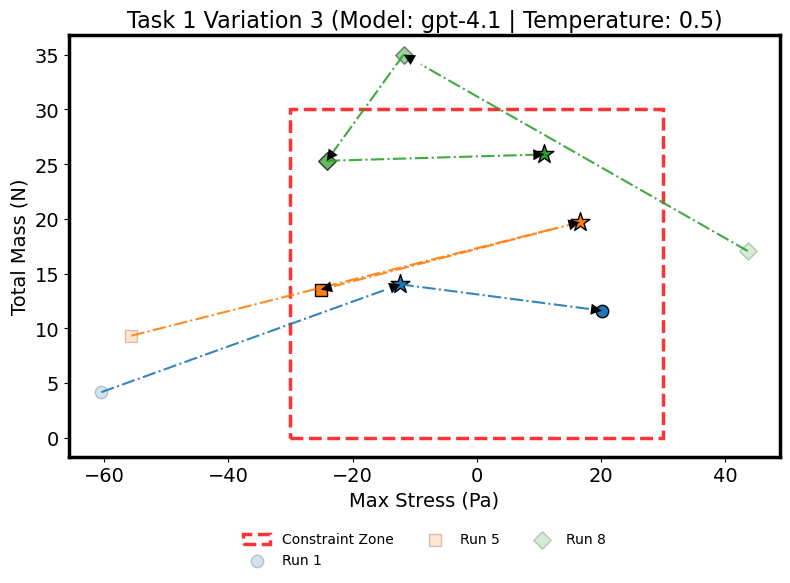

In [7]:
import numpy as np
import matplotlib.pyplot as plt

max_stress_allow = 30    # adjust as needed
total_mass_allow = 30    # adjust as needed

fig, ax = plt.subplots(figsize=(8,6))
n_runs = len(sorted_runs)

# ---- CUSTOM COLORS (your choice here) ----
custom_colors = [
    'tab:blue', 'tab:orange', 'tab:green', 'tab:red',
    'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
]

# Different markers for each run
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X']

# draw constraint zone
rect = plt.Rectangle(
    (-max_stress_allow, 0),
    2 * max_stress_allow, total_mass_allow,
    linewidth=2.5, edgecolor='red',
    facecolor='none', linestyle='--',
    alpha=0.8, label='Constraint Zone'
)
ax.add_patch(rect)

for idx, run in enumerate(sorted_runs):
    files = get_files_for_parent_run(parent, run)
    stress_vals, mass_vals = [], []
    for fn in files:
        with open(fn, 'r') as f:
            gen = ast.literal_eval(f.read())
        parsed = TrussOutput.model_validate(gen)
        t = make_truss(parsed.node_dict, parsed.member_dict, load, supports)
        _, res = make_result_dict(t.member_stress(), t.structure_mass(), print_=False)
        stress_vals.append(max(res['member_stress'].values(), key=abs))
        mass_vals.append(res['total_mass'])
    steps = np.arange(len(files))

    # pick color and marker for this run
    base_color = custom_colors[idx % len(custom_colors)]
    marker = marker_styles[idx % len(marker_styles)]

    # create a stronger gradient from very light to full color
    alphas = np.linspace(0.2, 1.0, len(steps))

    # ax.plot(stress_vals, mass_vals, '-.', color=base_color, alpha=1.0)

    # Step 1: Find steps inside constraint zone
    inside_zone = [
        i for i in range(len(stress_vals))
        if (abs(stress_vals[i]) <= max_stress_allow) and (mass_vals[i] <= total_mass_allow)
    ]

    if inside_zone:
        best_idx = inside_zone[np.argmin([abs(stress_vals[i]) for i in inside_zone])]
    else:
        def distance_from_zone(i):
            stress_over = max(0, abs(stress_vals[i]) - max_stress_allow)
            mass_over = max(0, mass_vals[i] - total_mass_allow)
            return np.sqrt(stress_over**2 + mass_over**2)

        best_idx = np.argmin([distance_from_zone(i) for i in range(len(stress_vals))])

    # Now plot all steps
    for i, step in enumerate(steps):
        lbl = f'Run {run.split("_")[1]}' if i == 0 else None
        if i == best_idx:
            # plot best point with a STAR
            ax.scatter(
                stress_vals[i], mass_vals[i],
                color=base_color, edgecolor='k', s=200,
                marker='*', label=None
            )
        else:
            ax.scatter(
                stress_vals[i], mass_vals[i],
                color=base_color, alpha=alphas[i],
                edgecolor='k', s=80,
                marker=marker,
                label=lbl
            )
            lbl = None

    for i in range(len(steps) - 1):
        x0, y0 = stress_vals[i], mass_vals[i]
        x1, y1 = stress_vals[i + 1], mass_vals[i + 1]
        
        dx = x1 - x0
        dy = y1 - y0
        line_portion = 0.95  # how far to draw dashed line
        x_line_end = x0 + line_portion * dx
        y_line_end = y0 + line_portion * dy

        # 1. Draw dashed colored line (no arrow)
        ax.plot(
            [x0, x_line_end],
            [y0, y_line_end],
            linestyle='-.',
            color=base_color,
            lw=1.5,
            alpha=0.9
        )

        # 2. Draw a SOLID black arrowhead only
        ax.annotate(
            '',
            xy=(x1, y1),
            xytext=(x_line_end, y_line_end),
            arrowprops=dict(
                arrowstyle='-|>',    # solid filled arrowhead only
                color='black',
                lw=0,                # shaft line width = 0 (invisible shaft)
                mutation_scale=20,   # bigger arrowhead size
                patchA=None, patchB=None,
                shrinkA=0, shrinkB=0
            )
        )

# Set labels and title
ax.set_xlabel('Max Stress (Pa)', fontsize=14)
ax.set_ylabel('Total Mass (N)', fontsize=14)
ax.set_title(f'Task 1 Variation 3 (Model: gpt-4.1 | Temperature: 0.5)', fontsize=16)

# Remove grid
ax.grid(False)

# Make borders thick
for spine in ax.spines.values():
    spine.set_linewidth(2.5)

# Make tick labels bigger
ax.tick_params(axis='both', which='major', labelsize=14)

# Move legend outside
ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),
    ncol=3,
    frameon=False
)

# Set x and y limits
# ax.set_xlim(-100, 100)
# ax.set_ylim(0, 100)

plt.tight_layout()
plt.savefig(f'./figures/task1_variation3__05{sorted_runs}.pdf', format="pdf" ,dpi=600, bbox_inches='tight')
plt.show()


In [8]:
# analysis_dict = {}
# for j in sorted_runs:
#     files = get_files_for_parent_run(parent, j)

#     r={}
#     stress_max_r = {}
#     mass_total_r = {}

#     for i in (range(len(files))):
#         # Read the file
#         with open(files[i], 'r') as f:
#             data = f.read()
        
#         gen_dict = (ast.literal_eval(data))
#         parsed_output = TrussOutput.model_validate(gen_dict)
#         node_dict_g = parsed_output.node_dict
#         member_dict_g = parsed_output.member_dict
#         t_gen = make_truss(node_dict_g, member_dict_g, load, supports)
#         # plot_truss(t_gen)
#         res, result_dict = make_result_dict(t_gen.member_stress(), t_gen.structure_mass(), print_= False)

#         r[i] = result_dict
#         stress_max_r[i] = max(result_dict["member_stress"].values(), key=lambda x: abs(x))
#         mass_total_r[i] = result_dict["total_mass"]



#     max_stress_allow = 15   # example value, set as needed
#     total_mass_allow = 30  # example value, set as needed

#     steps = np.arange(len(stress_max_r))
#     stress_vals = [stress_max_r[i] for i in steps]
#     mass_vals = [mass_total_r[i] for i in steps]

#     # Find the index of the min(abs(max stress)) (keep sign)
#     min_idx = np.argmin(np.abs(stress_vals))
    

#     # Find all indices that satisfy constraints
#     feasible_indices = [i for i in steps if abs(stress_vals[i]) <= max_stress_allow and mass_vals[i] <= total_mass_allow]
#     if feasible_indices:
#         min_feas_idx = min(feasible_indices, key=lambda i: abs(stress_vals[i]))
#     else:
#         min_feas_idx = None

#     # Normalize steps for colormap
#     norm = plt.Normalize(steps.min(), steps.max())
#     cmap = plt.cm.Blues
#     colors = cmap(norm(steps))

#     fig, ax = plt.subplots(figsize=(7,5))

#     # Draw constraint zone as a rectangle
#     rect = plt.Rectangle((-max_stress_allow, 0), 2*max_stress_allow, total_mass_allow,
#                         linewidth=1.5, edgecolor='red', facecolor='none', linestyle='--', alpha=0.8, label='Constraint Zone')

#     # plt.xlim(-100, 100)
#     # plt.ylim(0, 50)

#     ax.add_patch(rect)

#     for k in steps:
#         ax.scatter(stress_vals[k], mass_vals[k], color=colors[k], s=60, edgecolor='k')

#     if min_feas_idx is not None:
#         if abs(stress_vals[min_feas_idx]) <= max_stress_allow and mass_vals[min_feas_idx] <= total_mass_allow:
#             ax.scatter(stress_vals[min_feas_idx], mass_vals[min_feas_idx], color='g', marker='*', s=150, label='Best Feasible solution')

#     # Draw arrows from each step to the next
#     for p in range(len(steps)-1):
#         ax.annotate('',
#                     xy=(stress_vals[p+1], mass_vals[p+1]),
#                     xytext=(stress_vals[p], mass_vals[p]),
#                     arrowprops=dict(arrowstyle='->', lw=2, alpha=0.7))

#     sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#     sm.set_array([])

#     ax.set_xlabel('Max Stress')
#     ax.set_ylabel('Total Mass')
#     # ax.set_title(f'Max Stress vs Total Mass per Iteration Run {j.split("_")[1]}')
#     ax.grid(True, linestyle='--', alpha=0.5)
#     ax.legend(loc='upper right')

#     plt.tight_layout()
#     plt.show()

#     # --- Analysis dict for best design (min abs stress, red star) ---
#     # Use min_idx (red star, not necessarily feasible)
#     best_file = files[min_feas_idx]
#     with open(best_file, 'r') as f:
#         best_data = f.read()
#     best_gen_dict = (ast.literal_eval(best_data))
#     best_parsed_output = TrussOutput.model_validate(best_gen_dict)
#     best_node_dict = best_parsed_output.node_dict
#     best_member_dict = best_parsed_output.member_dict
#     num_nodes = len(best_node_dict)
#     num_connections = len(best_member_dict)
#     analysis_dict[j] = {
#         'num_nodes': num_nodes,
#         'num_connections': num_connections,
#         'node_dict': best_node_dict,
#         'member_dict': best_member_dict,
#         "structure": make_truss(best_node_dict, best_member_dict, load, supports),
#     }

#     plot_truss(analysis_dict[j]["structure"])
#     print(print(f"min_idx: {min_feas_idx}"))
#     print(files[min_feas_idx])

#     print("------------------------------------------------------------------------/n")

# # analysis_dict now contains number of nodes and connections for each run's best design (red star)